<div style="background: #fff; padding: 32px 24px; border-radius: 8px; display: flex; align-items: center;">
  <img src="https://github.com/iragca/pit-predictive-analysis/blob/master/notebooks/uselessfacts.png?raw=1" width="180" style="background: #fff; border-radius: 8px; margin-right: 32px;" />

  <div>
    <h2 style="font-size: 40px; color:#545454; font-weight: bold; margin-bottom: 0">Random Useless Facts API</h2>
    <span style="margin-top: 0; font-size: 20px; font-weight: bold; font-style: italic; color:#545454">Topic Modelling Using Latent Dirchlet Allocation (LDA) and BERTTopic </span>
    <p>
      <span style="font-size: 15px; font-weight: bold; font-style: italic; color:#545454">
      Chris Andrei Irag<br>
      Christine Joy Sorronda<br>
      Dane Casey Casiño<br>
      Genheylou Felisilda<br>
      Hernel Kenshin Juanico<br>
      </span>
    </p>
    <a href="https://colab.research.google.com/github/iragca/pit-predictive-analysis/blob/master/notebooks/1.0-random-useless-facts.ipynb" target="_blank" style="color: #ff751f; font-weight:bold;">Google Colab</a>
  </div>
</div>

## **Executive Summary**

This research explores the semantic structure of thousands of public trivia statements—commonly known as “useless facts”—retrieved from the Random Useless Facts API. Although these facts are informal and often humorous, they represent a rich and diverse corpus of short natural-language statements. By applying two major unsupervised topic modeling methods, Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF), the study examines whether the seemingly chaotic collection of trivia exhibits coherent underlying themes.

A complete computational pipeline is developed, encompassing data collection, text preprocessing, feature extraction, model training, topic evaluation, and visualization. The pipeline identifies recurring themes embedded in the trivia corpus, such as biological phenomena, animal-related oddities, historical anecdotes, linguistic curiosities, and surprising scientific facts. Beyond analyzing trivia, the project demonstrates how modern topic modeling can effectively uncover structure within unstructured, non-technical, and multilingual text sources. The resulting framework provides a repeatable method for analyzing similar short-form text datasets.

## **Table of Contents**

```bash
.
├── Title Section
│       ├── Executive Summary
│       ├── Table of Contents                   #  ⭐ You are here
│       └── Setup                               #  Libraries imports
├── Introduction
│       └── Problem Statement
├── Methodology
│       ├── Data Pipeline
│       ├── Data Exploration
│       ├── Text Processing
│       └── Modeling
├── Results and Discussion
└── Conclusion
```


## **Setup**

Before running this notebook make sure to have environment variables set: `SUPABASE_URL` and `SUPABASE_KEY`.


In [ ]:
import subprocess

from tqdm import tqdm


try:
    import google.colab  # type: ignore
    IS_COLAB_ENVIRONMENT = True
except ImportError:
    IS_COLAB_ENVIRONMENT = False

if IS_COLAB_ENVIRONMENT:
    from google.colab import userdata # type: ignore
    DEPENDENCIES = [
        "bertopic",
        "gensim"
        "iragca",
        "pydantic",
        "sentence-transformers",
        "supabase",
        "umap-learn",
    ]
    def install(package: str) -> None:
        subprocess.run(
            ["pip", "install", package],
            stdout=subprocess.DEVNULL
        )
    pbar = tqdm(DEPENDENCIES, desc="Installing dependencies")
    for package in pbar:
        pbar.set_description(f"Installing '{package}'")
        install(package)

In [ ]:
from enum import Enum
from functools import lru_cache
from itertools import batched, chain
import os
import random
from time import sleep as cooldown
from typing import Optional
from urllib.parse import urlencode, urljoin
import warnings


import dotenv
import httpx
import numpy as np
from iragca.matplotlib import Styles, Color
from iragca.functional import Pipeline
import matplotlib.pyplot as plt
from pydantic import BaseModel
import seaborn as sns
from supabase import Client, create_client
import torch

dotenv.load_dotenv()
plt.style.use(Styles.ML.value)
warnings.filterwarnings("ignore")

# **Introduction**

“Useless facts” are pieces of trivia or curious fragments of information that are often surprising, entertaining, or obscure, yet rarely practical in daily life. Despite their seemingly trivial nature, these factoids circulate widely across digital platforms—particularly on social media, blogs, online forums, and dedicated trivia websites—where they captivate audiences by appealing to people’s natural curiosity and fascination with unexpected knowledge. The Random Useless Facts API serves as a public web service that aggregates thousands of these items, enabling programmatic access to randomly selected facts in multiple languages, including English and German. Each retrieved entry typically contains the text of the fact itself, a unique identifier, metadata regarding its original source, and a stable permalink for reference. The structured yet diverse nature of this content creates an opportunity for systematic computational analysis.

This study investigates the underlying semantic patterns present within a large collection of such “useless facts” through the use of topic modeling, a class of unsupervised machine learning methods designed to identify latent themes in textual data. Topic modeling algorithms group documents—here, individual fact statements—based on shared vocabulary and co-occurrence patterns, allowing researchers to uncover meaningful clusters without requiring manually annotated categories. To explore the thematic composition of the dataset, we implement and compare two widely used topic modeling approaches: Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF). These models provide complementary perspectives on the structure of the corpus, revealing which recurring subjects—such as animals, historical events, linguistic oddities, biological phenomena, or everyday objects—are most prevalent within the collection.

To conduct this analysis, a complete machine learning pipeline is developed, covering all essential stages of text-based research. This pipeline begins with programmatically retrieving data from the API, followed by cleaning, preprocessing, and normalizing the text to ensure suitability for quantitative analysis. The next phase involves transforming the processed text into numerical feature representations using vectorization techniques such as TF-IDF and Bag-of-Words. These representations serve as inputs to the LDA and NMF models, which are then trained, tuned, and evaluated to determine the most coherent and interpretable topic structures. Finally, the identified topics are visualized, interpreted, and examined for linguistic and thematic insights. This end-to-end workflow ensures methodological rigor, reproducibility, and scalability, establishing a robust framework that can readily be adapted for analyzing similar text-rich datasets.

## **Problem Statement**

Trivia content labeled as “useless facts” is characterized by its randomness, brevity, and lack of practical application. At first glance, these statements appear disconnected and purely humorous. However, when collected in large quantities, they may contain underlying patterns or recurring themes that are not immediately obvious. Despite their mundaneness, such facts could still reflect shared human interests, common cultural references, or frequently occurring knowledge domains.

This leads to the central problem guiding this study:

**What are the most common topics being observed despite the mundaneness of the subject matter?**

Addressing this question presents several methodological challenges:

1. Lack of inherent structure — “Useless facts” are not categorized by subject, making thematic grouping non-trivial.

2. Short and noisy text format — Each fact is typically only one or two sentences long, limiting contextual information that topic modeling methods rely on.

3. Semantic diversity — The corpus contains a wide range of content (biology, history, humor, linguistics, science, etc.), but without any explicit labeling.

4. Multilingual nature — The inclusion of multiple languages (e.g., English and German) introduces linguistic variability that complicates preprocessing and modeling.

5. Absence of ground-truth categories — Because there is no predefined taxonomy of “useless facts,” fully unsupervised methods are required to identify meaningful patterns.

Given these challenges, the aim is to determine whether coherent themes can still emerge from such random and seemingly trivial content. Through topic modeling techniques such as Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF), this study seeks to uncover the dominant themes present within the corpus, revealing the types of subjects people inadvertently encode into what is commonly perceived as insignificant information.

# **Methodology**

[![](https://mermaid.ink/img/pako:eNpVkU9rwkAQxb_KMoeeoiRuTHQPBesfKFQoRXpo4mFJxriQ7KaT3dYqfvcmEQnuad_83pt3mAtkJkcQcCjNb3aUZNnbR6pZ-xbJSlrJFtm3U42yyug9u5HR6Jm9JDs8WfZOWJPJsGmULvYDXiYblNYRsrUulEakR75KdqZWGdu27eUjWif9kK1_ZOlk3zvATfKpGidLde4Je2Kv2iLVhPZuBQ8KUjkISw49qJAq2Um4dGtSsEesMAXRfnM8SFfaFFJ9bWO11F_GVPckGVccQRxk2bTK1bm0uFKyIDlYUOdIS-O0BRFM-hUgLnACMfGDcRQHM-5PoyjmMece_LUmfz7uRDDnnMfhNAqvHpz7Vn88D-IoCMNZi3nEuwTmyhra3m7Un-r6D6NqiAI?type=png)](https://mermaid.live/edit#pako:eNpVkU9rwkAQxb_KMoeeoiRuTHQPBesfKFQoRXpo4mFJxriQ7KaT3dYqfvcmEQnuad_83pt3mAtkJkcQcCjNb3aUZNnbR6pZ-xbJSlrJFtm3U42yyug9u5HR6Jm9JDs8WfZOWJPJsGmULvYDXiYblNYRsrUulEakR75KdqZWGdu27eUjWif9kK1_ZOlk3zvATfKpGidLde4Je2Kv2iLVhPZuBQ8KUjkISw49qJAq2Um4dGtSsEesMAXRfnM8SFfaFFJ9bWO11F_GVPckGVccQRxk2bTK1bm0uFKyIDlYUOdIS-O0BRFM-hUgLnACMfGDcRQHM-5PoyjmMece_LUmfz7uRDDnnMfhNAqvHpz7Vn88D-IoCMNZi3nEuwTmyhra3m7Un-r6D6NqiAI)

## **Data Pipeline**


Our goal in constructing a simple data pipeline is to enable downstream stakeholders (ML engineers, data analysts, or in this case, my groupmates) to receive data efficiently, obtain clean and reliable datasets, and interact with APIs or data warehouses seamlessly through well-documented interfaces.

Firstly, we must define a standard representation for our data, which are "facts". These will be the elemental building blocks, so that each module in the pipeline knows exactly how to interface with the data as it flows through. To achieve this, we create a `Fact` object with the following properties: `id`, `text`, `source`, `source_url`, `language`, and `permalink`. `Language` can only be either English or German due to what is only supported in the original API.

In [ ]:
class Language(str, Enum):
    """
    Enumeration of supported languages for the Random Useless Facts API.

    Each enum member corresponds to the language code expected by the
    remote API.
    """
    ENGLISH = "en"
    GERMAN = "de"

class Fact(BaseModel):
    """
    Data model representing a response returned by the Random Useless Facts API.

    Parameters
    ----------
    id : str
        Unique identifier of the fact.
    text : str
        The textual content of the fact.
    source : str
        Origin or reference for the fact.
    source_url : str
        URL pointing to the source.
    language : Language
        Language in which the fact is written.
    permalink : str
        Permanent URL for accessing the fact.

    Notes
    -----
    This model is parsed from JSON using Pydantic and ensures type validation
    of the incoming API response.
    """
    id: str
    text: str
    source: str
    source_url: str
    language: Language
    permalink: str

    def __hash__(self) -> int:
        return hash(self.id)

<img src="https://github.com/iragca/pit-predictive-analysis/blob/master/notebooks/data-pipeline.png?raw=1" alt="data-pipeline" width=400/>

The two main modules we will construct is an API wrapper for the 'Random Useless Facts' API and a data warehouse module to interface with our datawarehouse/database easily, mainly we will be using [Supabase](https://supabase.com/).


### **API Wrapper**

Our goal with the API wrapper `RandomUselessFactAPI` is to abstract the complexity of raw API calls, providing a clean and consistent interface for data acquisition. By encapsulating the details of URL construction, query parameter encoding, and HTTP requests, the wrapper allows downstream users and modules to retrieve data reliably and efficiently without worrying about the underlying implementation.

This approach also ensures that data is returned in a standardized format (in this case, as `Fact` objects), making it easier to integrate with pipelines, analytics workflows, or other applications that consume the API.

#### **Main Features**

* **Data Retrieval**
  * Retrieve a single random language-specifc fact (Default: English).

In [ ]:
class RandomUselessFactAPI:
    """
    Client for interacting with the Random Useless Facts API.

    Parameters
    ----------
    base_url : str, optional
        Base URL of the API. Defaults to ``"https://uselessfacts.jsph.pl/"``.

    Notes
    -----
    This class exposes convenience methods to construct API URLs and retrieve
    random facts in various languages. Requests are executed using ``httpx``.
    """
    def __init__(self, base_url: str ="https://uselessfacts.jsph.pl/") -> None:
        self.base_url = base_url

    def get_random_fact(self, language: Language = Language.ENGLISH) -> Fact:
        """
        Retrieve a random useless fact.

        Parameters
        ----------
        language : Language, optional
            Language in which the fact should be returned. Defaults to
            ``Language.ENGLISH``.

        Returns
        -------
        Response
            Parsed API response containing the random fact.

        Raises
        ------
        httpx.HTTPError
            If the request fails or returns an error status code.

        Examples
        --------
        >>> api = RandomUselessFactAPI()
        >>> fact = api.get_random_fact()
        >>> fact.text
        'Banging your head against a wall for one hour burns 150 calories.'
        """
        url = self._build_random_fact_url(language)
        response = httpx.get(url)
        response.raise_for_status()
        data = response.json()

        return Fact(**data)

    def _build_random_fact_url(self, language: Optional[Language] = None) -> str:
        """
        Construct the request URL for fetching a random fact.

        Parameters
        ----------
        language : Optional[Language], optional
            Language code to include as a query parameter. Defaults to
            ``None``.

        Returns
        -------
        str
            Fully constructed URL pointing to the random fact endpoint.

        Notes
        -----
        This method is internal and is not intended to be called directly by
        users. It performs safe URL joining and query parameter encoding.
        """
        ENDPOINT = "api/v2/facts/random"
        path = urljoin(self.base_url, ENDPOINT)

        if language is not None:
            params = urlencode({"language": language.value})
            return f"{path}?{params}"
        return path


### **Data Warehouse**

Our goal with the data warehouse wrapper, `SupabaseStorage`, is to provide a reliable and consistent interface for downstream stakeholders (Machine Learning Engineers, Analysts, etc.) to access and retrieve data through well-documented APIs. This abstraction ensures that users can focus on analyzing and using the data without worrying about the underlying database or query details.

#### **Main Features**

* **Data Ingestion**

  * Insert one or multiple facts efficiently.
* **Data Retrieval**

  * Retrieve all facts stored in the warehouse.
  * Retrieve all facts specifically in English for language-specific analysis.


In [ ]:
class SupabaseStorage:
    """
    Storage interface for interacting with the Supabase `facts` table.

    This class handles:
    - Environment variable loading for Supabase credentials
    - Inserting single or multiple facts into the database
    - Retrieving all stored facts

    Attributes
    ----------
    supabase : supabase.Client
        Initialized Supabase client used for database operations.

    Raises
    ------
    ValueError
        If required Supabase environment variables are missing.
    """
    def __init__(self) -> None:
        """
        Initialize the Supabase client using environment variables.

        The method attempts to load the Supabase URL and API key using
        `load_env`. If either value is missing, an exception is raised.

        Raises
        ------
        ValueError
            If `SUPABASE_URL` or `SUPABASE_KEY` is not set.
        """
        env = self.load_env()
        if env and all(env.values()):
            self.supabase: Client = create_client(env["url"], env["key"])
        else:
            raise ValueError("SUPABASE_URL and SUPABASE_KEY must be set in environment variables.")

    @lru_cache
    def insert_fact(self, fact: Fact):
        """
        Insert a single fact into the Supabase `facts` table.

        This method is cached with an LRU cache of size 1.

        Parameters
        ----------
        fact : Fact
            The fact object to be inserted into the database.

        Returns
        -------
        supabase.lib.client_response.ClientResponse
            Response object returned by the Supabase insert operation.
        """
        response = self.supabase.table("facts").insert(fact.model_dump()).execute()
        return response

    def insert_facts(self, facts: list[Fact]):
        """
        Insert multiple facts into the Supabase `facts` table.

        Parameters
        ----------
        facts : list of Fact
            A list of fact objects to be inserted.

        Returns
        -------
        supabase.lib.client_response.ClientResponse
            Response object returned by the Supabase bulk insert operation.
        """
        response = self.supabase.table("facts").insert([fact.model_dump() for fact in facts]).execute()
        return response

    def get_all_facts(self) -> list[Fact]:
        """
        Retrieve all facts from the Supabase `facts` table.

        Returns
        -------
        list of Fact
            A list of `Fact` objects reconstructed from the database records.
        """
        response = self.supabase.table("facts").select("*").execute()
        data = response.data
        return [Fact(**item) for item in data]

    def get_english_facts(self) -> list[Fact]:
        """
        Retrieve only English facts from the Supabase `facts` table.

        Returns
        -------
        list of Fact
            A list of `Fact` objects reconstructed from the database records
            where the language is English.
        """
        response = self.supabase.table("facts").select("*").eq("language", Language.ENGLISH.value).execute()
        data = response.data
        return [Fact(**item) for item in data]

    @staticmethod
    def load_env():
        """
        Load Supabase environment variables.

        This method supports both Google Colab and standard local
        environment variable loading.

        Returns
        -------
        dict
            Dictionary containing:
            - `"url"` : str
                Supabase project URL.
            - `"key"` : str
                Supabase API key.
        """
        if IS_COLAB_ENVIRONMENT:
            url: str = userdata.get("SUPABASE_URL")
            key: str = userdata.get("SUPABASE_KEY")
        else:
            url: str = os.environ.get("SUPABASE_URL", "")
            key: str = os.environ.get("SUPABASE_KEY", "")
        return {"url": url, "key": key}

### **Ingesting Data**

In this section we showcase a general application of our data pipeline:

- Getting data from the API
- Storing that data to the data warehouse

In [ ]:
# Instantiate API client and storage interface
api = RandomUselessFactAPI()
storage = SupabaseStorage()

In [ ]:
# Fetch and print a random useless fact in English
fact: Fact = api.get_random_fact(language=Language.ENGLISH)
print(fact.text)

The most common street name in the U.S. is Second Street.


In [ ]:
fact

Fact(id='ee9963476ac14791751f095e554d7bf2', text='The most common street name in the U.S. is Second Street.', source='djtech.net', source_url='http://www.djtech.net/humor/useless_facts.htm', language=<Language.ENGLISH: 'en'>, permalink='https://uselessfacts.jsph.pl/api/v2/facts/ee9963476ac14791751f095e554d7bf2')

We write a simple script to get `Facts` from the 'Random Useless Facts' API, then store the data in batches to the data warehouse.

In [ ]:
# @title Data Acquisition and Ingestion script {"vertical-output":true,"display-mode":"form"}
FETCH_COUNT = 0 # @param {"type":"integer","placeholder":"0"}
BATCH_SIZE = 0 # @param {"type":"integer","placeholder":"0"}
LANGUAGE = "en" # @param ["en","de"]


def fetch_facts(count: int, cooldown_sec: int = 1) -> list[Fact]:
    facts = []
    for _ in tqdm(range(count), desc="Fetching facts"):
        fact = api.get_random_fact(language=Language(LANGUAGE)) #Parse facts only in English
        facts.append(fact)
        cooldown(cooldown_sec)  # To avoid hitting rate limits
    return list(set(facts)) # Remove duplicates by converting to set and back to list

# Fetch facts from the API
facts = fetch_facts(FETCH_COUNT)

failed_batches = []

# Insert facts into Supabase in batches
if FETCH_COUNT > 0:
    for batch in tqdm(batched(facts, BATCH_SIZE), total=len(facts) / BATCH_SIZE, desc="Batch ingest"):
        try:
            storage.insert_facts(list(batch))
        except Exception as e:
            failed_batches.append(list(batch))


    errors = []

    # Retry failed inserts individually
    if failed_batches:
        failed_batches = chain.from_iterable(failed_batches)
        for fact in tqdm(failed_batches, desc="Retrying failed inserts"):
            try:
                storage.insert_fact(fact)
            except Exception as e:
                errors.append((fact, str(e)))

    # Analyze errors for duplicates
    duplicate_count = sum(1 for fact, error in errors if "duplicate" in error.lower())
    print("Duplicate errors:", duplicate_count)

Fetching facts: 0it [00:00, ?it/s]


## **Data Exploration**

In [ ]:
facts = storage.get_all_facts()
len(facts)

1501

In [ ]:
facts

[Fact(id='a79df1c3d4ee87fa1c6ffb798cb6c3d1', text='Approximately every seven minutes of every day, someone in an aerobics class pulls their hamstring.', source='djtech.net', source_url='http://www.djtech.net/humor/useless_facts.htm', language=<Language.ENGLISH: 'en'>, permalink='https://uselessfacts.jsph.pl/api/v2/facts/a79df1c3d4ee87fa1c6ffb798cb6c3d1'),
 Fact(id='9930af0979d0b01ffa1311000e6cf29c', text='The country code for Russia is "007".', source='djtech.net', source_url='https://www.djtech.net/humor/shorty_useless_facts.htm', language=<Language.ENGLISH: 'en'>, permalink='https://uselessfacts.jsph.pl/api/v2/facts/9930af0979d0b01ffa1311000e6cf29c'),
 Fact(id='38583dc74ede6858ca400242b81efd8d', text='Steely Dan got their name from a sexual device depicted in the book `The Naked Lunch`. \xa0', source='djtech.net', source_url='http://www.djtech.net/humor/useless_facts.htm', language=<Language.ENGLISH: 'en'>, permalink='https://uselessfacts.jsph.pl/api/v2/facts/38583dc74ede6858ca400242

In [ ]:
english_facts = storage.get_english_facts()
print(f"Number of English facts: {len(english_facts)}")

Number of English facts: 1001


In [ ]:
english_fact_texts = [fact.text for fact in english_facts]

print(f"Total number of English fact texts extracted: {len(english_fact_texts)}")
print("\nFirst 5 extracted fact texts:")
for i, text in enumerate(english_fact_texts[:5]):
    print(f"{text}")

Total number of English fact texts extracted: 1001

First 5 extracted fact texts:
Approximately every seven minutes of every day, someone in an aerobics class pulls their hamstring.
The country code for Russia is "007".
Steely Dan got their name from a sexual device depicted in the book `The Naked Lunch`.  
Human thigh bones are stronger than concrete.
Starfish have no brains.


## **Text Processing**

In [ ]:
import pandas as pd

import nltk
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import LdaModel
from sklearn.decomposition import LatentDirichletAllocation

### **Downloading Required NLTK Resources**

Before performing any text preprocessing tasks such as tokenization, stopword removal, and lemmatization, we need to download several NLTK resource packages:

- **punkt_tab** – Provides pretrained models for tokenizing text into words and sentences.
- **stopwords** – Contains lists of commonly removed words (e.g., “the”, “is”, “and”).
- **wordnet** – A lexical database used for lemmatization (reducing words to their root form).

These resources are not included by default in NLTK, so we download them to ensure preprocessing functions work properly.

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /home/iragca/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/iragca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iragca/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **Preprocessing Pipeline**


Our preprocessing pipeline aims to standardize and clean the textual data before model training, so that we maximize information gain and minimize noise to improve model performance and generalization.

<img src="https://github.com/iragca/pit-predictive-analysis/blob/master/notebooks/preprocessing-pipeline.jpg?raw=1" alt="data-pipeline" width=800/>

The pipeline first removes special characters to retain only alphabetic tokens, followed by converting all text to lowercase to reduce case-based variations. We then tokenize the text into individual words and remove stopwords, keeping only meaningful tokens longer than two characters. Next, we lemmatize the tokens to reduce inflected forms to their canonical forms, and expand contractions to their full representations (e.g., "don’t" → "do not"). Finally, the tokens are joined back into a single string to produce the processed text.

We formalize these steps as functions with their respective implementation in the following code cell:

In [ ]:
def remove_special_characters(text: str) -> str:
    """
    Remove special characters from the input text, retaining only
    alphabetic characters and whitespace.

    Notes
    -----
    The pattern used captures that isn't `^` a: (1) lowercase alphabetical
    characeter `a-z`, (2) uppercase alphabetical character `A-Z`, and (3)
    whitespace `\\s`.

    Integers, punctuation, and other special characters are removed.
    Not recommended for cases where the topic
    is a certain year, 2024, as an example.
    """
    pattern = r'[^a-zA-Z\s]'
    return re.sub(pattern, '', text)

def remove_stopwords(tokens: list[str]) -> list[str]:
    """
    Remove English stopwords from the list of tokens.

    Notes
    -----
    Removes common English stopwords as defined in NLTK's stopword corpus.
    Also filters out tokens with length less than or equal to 2.
    """
    sw = set(stopwords.words('english'))
    return [
        word for word in tokens
        if word not in sw and len(word) > 2
    ]

def lemmatize_tokens(tokens: list[str]) -> list[str]:
    """
    Lemmatizes the list of tokens using WordNetLemmatizer.

    Examples
    --------
    >>> tokens = ["running", "jumps", "easily"]
    >>> lemmatize_tokens(tokens)
    ['running', 'jump', 'easily']
    """
    stem = WordNetLemmatizer()
    return [stem.lemmatize(word) for word in tokens]

def fix_contractions(tokens: list[str]) -> list:
    """
    Expands contractions in the list of tokens.

    Examples
    --------
    >>> tokens = ["don't", "can't", "it's"]
    >>> fix_contractions(tokens)
    ['do not', 'cannot', 'it is']
    """
    return [contractions.fix(word) for word in tokens]

def join_tokens(tokens: list[str]) -> str:
    """
    Join a list of tokens back into a single space-separated string.

    Examples
    --------
    >>> tokens = ["This", "is", "a", "test"]
    >>> join_tokens(tokens)
    'This is a test'
    """
    return ' '.join(tokens)

We then compose the preprocessing steps into a sequential `Pipeline`.

In [ ]:
preprocessing_pipeline = Pipeline(
    steps=[
      remove_special_characters,
      str.lower,
      word_tokenize,
      remove_stopwords,
      lemmatize_tokens,
      fix_contractions,
      join_tokens
    ]
)
print(preprocessing_pipeline)

Pipeline(
  <function remove_special_characters at 0x7f621cad19e0>
    ⬇
  <method 'lower' of 'str' objects>
    ⬇
  <function word_tokenize at 0x7f621e34aac0>
    ⬇
  <function remove_stopwords at 0x7f621cad1a80>
    ⬇
  <function lemmatize_tokens at 0x7f621cad1b20>
    ⬇
  <function fix_contractions at 0x7f621cad1bc0>
    ⬇
  <function join_tokens at 0x7f621cad1c60>
)


Apply the preprocessing pipeline to the entire English random useless facts corpus.

In [ ]:
pp_text_eng = [preprocessing_pipeline(doc) for doc in english_fact_texts]
pp_text_eng[0:5]

['approximately every seven minute every day someone aerobics class pull hamstring',
 'country code russia',
 'steely dan got name sexual device depicted book naked lunch',
 'human thigh bone stronger concrete',
 'starfish brain']

## **Modeling**


This section utilizes the implementation of the Latent Dirchlet Allocation with Sklearn. This aims to find hidden topics in documents and are represented by a variety of the most defined topics without prior labels.

We set a random state of 42 for reproducibility for all libraries `NumPy`, `random` and `PyTorch`. Unfortunately, full reproducibility cannot be achieved due to some models that use probabilistic algorithms.

In [ ]:
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(False)  #   Setting to True will cause errors, since the models are not fully deterministic

### **Latent Dirchlet Allocation (LDA) Using Sklearn**

suggestion(outline): model intuition, what we are doing

In [ ]:
cv = CountVectorizer(max_features=128, stop_words='english')
doc_term_matrix = cv.fit_transform(pp_text_eng)

#We can explore 128 out of the 1001 english facts
#We need a reason why but we can narrow down what topics
#Topics that ae quite common but will be reducefd further to the LDA

feature_names = cv.get_feature_names_out()

In [ ]:
lda = LatentDirichletAllocation(
    n_components = 4, #number of topics to allocate
    random_state=RANDOM_STATE, #for reproducibility
    max_iter = 28
)

lda.fit(doc_term_matrix)

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",4
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",28
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [ ]:
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-5:][::-1]  # Get top 5 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: world, word, english, eye, letter
Topic 2: human, american, people, average, city
Topic 3: year, state, people, average, person
Topic 4: time, day, mile, year, average


In [ ]:
pp_text_eng_lda = lda.transform(doc_term_matrix)
df_lda = pd.DataFrame(
    pp_text_eng_lda.round(3),
    columns=[f'Topic {i+1}' for i in range(4)],
    index=[f'Doc {i+1}' for i in range(len(pp_text_eng))]
)
df_lda.T

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,...,Doc 992,Doc 993,Doc 994,Doc 995,Doc 996,Doc 997,Doc 998,Doc 999,Doc 1000,Doc 1001
Topic 1,0.063,0.625,0.625,0.413,0.125,0.25,0.083,0.125,0.25,0.25,...,0.063,0.125,0.25,0.125,0.125,0.063,0.130,0.063,0.087,0.063
Topic 2,0.063,0.125,0.125,0.418,0.625,0.25,0.083,0.128,0.25,0.25,...,0.063,0.132,0.25,0.613,0.125,0.063,0.125,0.064,0.412,0.811
Topic 3,0.063,0.125,0.125,0.086,0.125,0.25,0.750,0.622,0.25,0.25,...,0.063,0.125,0.25,0.137,0.125,0.063,0.125,0.809,0.083,0.064
Topic 4,0.812,0.125,0.125,0.083,0.125,0.25,0.083,0.125,0.25,0.25,...,0.812,0.618,0.25,0.125,0.625,0.812,0.620,0.065,0.417,0.063


(0.0, 0.31045454545454537)

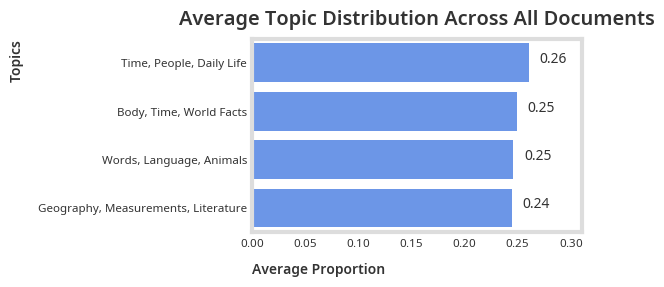

In [ ]:

# Calculate average topic proportions across all documents
average_topic_proportions = df_lda.mean()

# Define new topic names based on top words
new_topic_names = {
    'Topic 1': 'Words, Language, Animals',
    'Topic 2': 'Time, People, Daily Life',
    'Topic 3': 'Geography, Measurements, Literature',
    'Topic 4': 'Body, Time, World Facts'
}

# Map the new names to the average_topic_proportions index
# Using .copy() to avoid SettingWithCopyWarning if average_topic_proportions was a slice
pie_data = average_topic_proportions.rename(index=new_topic_names).copy().sort_values(ascending=False)

sns.barplot(
    y=pie_data.index,
    x=pie_data.values,
    orient='h',
)

for i, v in enumerate(pie_data.values):
    plt.text(v + 0.01 , i, f"{v:.2f}", color=Color.SOFT_BLACK.value, ha='left')
plt.xlabel('Average Proportion')
plt.ylabel('Topics')
plt.title('Average Topic Distribution Across All Documents')
plt.xlim(0, max(pie_data.values) + 0.05)

### **Using BERTTopic**

suggestion(outline): model intuition, what we are doing

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

In [ ]:
embedding_model = SentenceTransformer("all-mpnet-base-v2")

model = BERTopic(embedding_model=embedding_model)

In [ ]:
topics, probabilities = model.fit_transform(pp_text_eng)
print(f"BERTopic model fitted. Number of topics found: {len(model.get_topics())}")

BERTopic model fitted. Number of topics found: 23


In [ ]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,416,-1_every_year_world_human,"[every, year, world, human, time, one, cat, fi...",[average lead pencil draw line mile long write...
1,0,104,0_name_first_invented_named,"[name, first, invented, named, song, disney, j...","[first pressed bruce springsteens born usa, fi..."
2,1,51,1_word_english_language_letter,"[word, english, language, letter, longest, sen...","[word english language rhyme month, word engli..."
3,2,44,2_eye_bird_head_see,"[eye, bird, head, see, fish, eyelid, ostrich, ...",[dolphin look different direction eye sleep on...
4,3,42,3_ketchup_peanut_tree_cocacola,"[ketchup, peanut, tree, cocacola, apple, plant...",[half food eaten throughout world today develo...
5,4,42,4_average_calorie_eat_celery,"[average, calorie, eat, celery, american, day,...",[celery negative calorie take calorie eat piec...
6,5,41,5_tongue_muscle_body_water,"[tongue, muscle, body, water, striped, crocodi...","[relative size strongest muscle body tongue, s..."
7,6,29,6_bone_foot_growing_faster,"[bone, foot, growing, faster, never, grow, sto...",[eye always size birth nose ear never stop gro...
8,7,26,7_city_largest_island_country,"[city, largest, island, country, mile, world, ...","[philippine island square mile area, columbia ..."
9,8,24,8_people_crash_killed_died,"[people, crash, killed, died, horse, injured, ...",[statue park horse front leg air person died b...


In [ ]:
model.visualize_topics()

Text(0, 1, 'Topics')

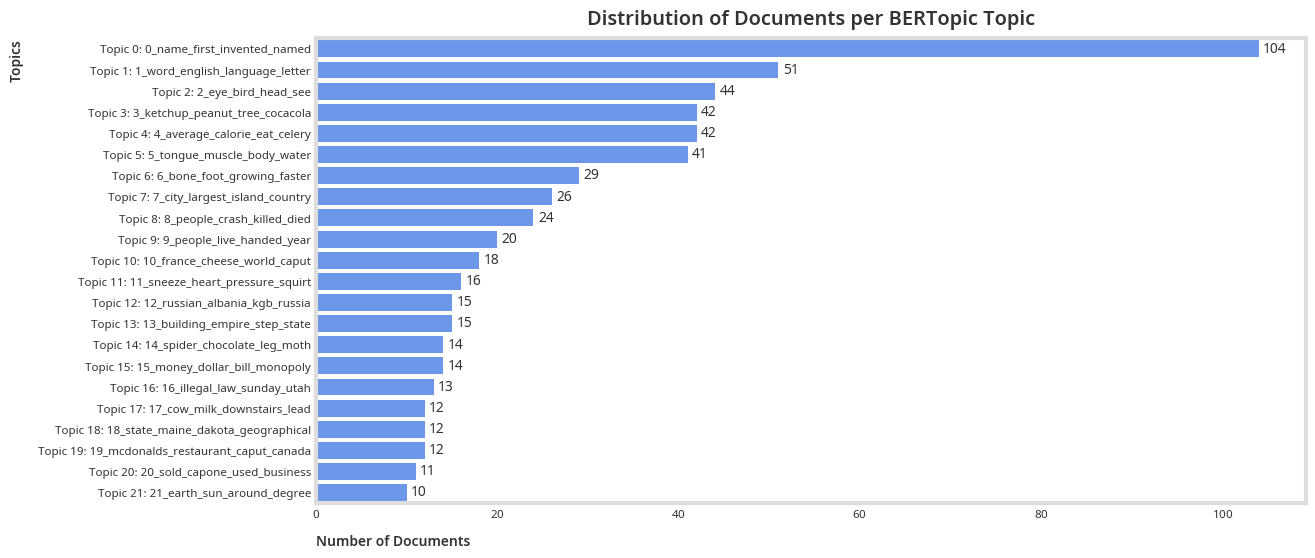

In [ ]:
# Get topic information and count documents per topic
topic_counts = model.get_topic_info()
# Filter out the -1 topic (outliers) if needed, or keep it
topic_counts = topic_counts[topic_counts['Topic'] != -1].copy().sort_values(by='Count', ascending=False)
topic_counts['Count'] = topic_counts['Count'].astype(int)

# Prepare data for pie chart
pie_labels = [f"Topic {row.Topic}: {row.Name}" for idx, row in topic_counts.iterrows()]
pie_values = topic_counts['Count'].values

plt.figure(figsize=(12, 6))
sns.barplot(
    x=pie_values,
    y=pie_labels,
    orient='h'
)
for i, v in enumerate(pie_values):
    plt.text(v + 0.5 , i + 0.15, f"{v}", color=Color.SOFT_BLACK.value, ha='left')

plt.title('Distribution of Documents per BERTopic Topic')
plt.xlabel('Number of Documents')
plt.ylabel('Topics')

# **Results and Discussion**

# **Conclusion**

## **Acronyms**

`API` Application Programming Interface

## **Acknowledgements**

This work benefited from the assistance of large language models for tasks such as literature discovery, writing support, and code autocompletion. All ideas and methodological decisions were conceived and developed by the authors, with inspiration drawn from relevant prior work.